<a href="https://colab.research.google.com/github/Rajagopal-Jahnavi/GroupProject/blob/main/water_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import datasets,models, layers
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
#Set all the Constants
BATCH_SIZE = 105
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=5

In [ ]:
#Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Water Bodies Dataset",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
    
)

Found 286 files belonging to 6 classes.


# New Section

In [ ]:
class_names = dataset.class_names
class_names

['Images', 'mud water', 'muddy', 'oil', 'oil water', 'pure water']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(105, 300, 300, 3)
[1 4 5 5 1 5 1 4 1 1 1 4 4 1 0 1 4 1 4 4 1 5 1 5 1 5 0 4 1 4 4 5 1 5 1 0 1
 5 1 5 5 0 1 1 0 4 1 0 1 4 5 4 5 1 4 5 1 4 1 4 4 5 5 4 4 5 4 0 4 5 1 1 1 1
 1 1 5 1 5 5 5 1 4 5 5 4 5 1 5 5 1 1 0 3 1 0 4 5 5 0 1 4 3 5 1]


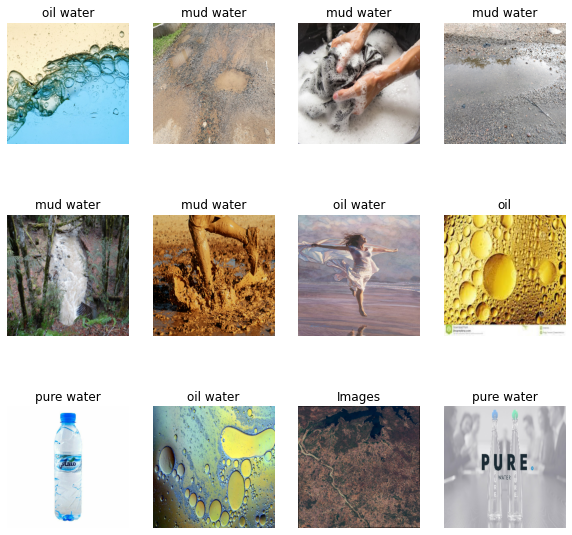

In [ ]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#Function to Split Dataset
len(dataset)

3

In [ ]:
train_size = 0.5
len(dataset)*train_size

1.5

In [ ]:
train_ds = dataset.take(1)
len(train_ds)

1

In [ ]:
test_ds = dataset.skip(1)
len(test_ds)

2

In [ ]:
val_size=0.5
len(dataset)*val_size

1.5

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)


1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.4, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)

1

In [ ]:
len(val_ds)

1

In [ ]:
len(test_ds)



1

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Model Architecture
model = Sequential()
inputShape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = 3

model.add(Conv2D(64, (3, 3),input_shape=inputShape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3) ))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 298, 298, 64)      1792      
                                                                 
 activation_40 (Activation)  (None, 298, 298, 64)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 149, 149, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 147, 147, 64)      36928     
                                                                 
 activation_41 (Activation)  (None, 147, 147, 64)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                

In [ ]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras. losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: nan - accuracy: 0.3143 - val_loss: nan - val_accuracy: 0.0857
Epoch 2/50
1/1 [==============================] - 0s 422ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 3/50
1/1 [==============================] - 0s 419ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 4/50
1/1 [==============================] - 0s 425ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 5/50
1/1 [==============================] - 0s 422ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 6/50
1/1 [==============================] - 0s 417ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 7/50
1/1 [==============================] - 0s 418ms/step - loss: nan - accuracy: 0.0952 - val_loss: nan - val_accuracy: 0.0857
Epoch 8/50
1/1 [==============================] - 0s 457ms/step -

NameError: ignored

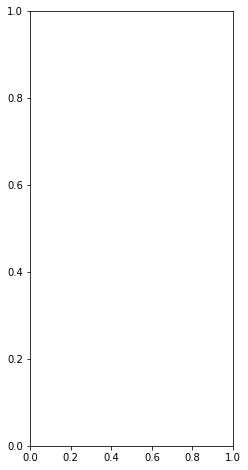

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")